In [1]:
import torch, pickle, argparse
import importlib
from fig_settings import *

In [2]:
params = torch.load('material_model_run_3/args.pkl', weights_only=True)
args = argparse.Namespace(**params)   

In [17]:
mm = importlib.import_module(args.material_model)
from util import LossFunction
from m_encoder import *

device = torch.device(args.device if torch.cuda.is_available() else "cpu")

with open(args.data_path, "rb") as f:
    data = pickle.load(f)


N = args.n_samples
step = args.step

e = torch.tensor(data["strain"][:N, ::step], dtype=torch.float32).to(device)
e_dot = torch.tensor(data["strain_rate"][:N, ::step], dtype=torch.float32).to(device)
s = torch.tensor(data["stress"][:N, ::step], dtype=torch.float32).to(device)
E = torch.tensor(data["E"][:N], dtype=torch.float32).to(device)
nu = torch.tensor(data["nu"][:N], dtype=torch.float32).to(device)

loss_function = LossFunction()

ae_E = AutoEncoder(E.shape[1], args.encoder_hidden_dim, args.encoder_latent_dim).to(
    device
)
ae_nu = AutoEncoder(nu.shape[1], args.encoder_hidden_dim, args.encoder_latent_dim).to(
    device
)

ae_E.load_state_dict(torch.load(f"{args.encoder_path}/ae_E.pth", weights_only=True, map_location=torch.device('cpu')))
ae_nu.load_state_dict(torch.load(f"{args.encoder_path}/ae_nu.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
E.shape, E_recon.shape

(torch.Size([1000, 501]), (1000, 501))

E reconstruction error: 0.09385267645120621
nu reconstruction error: 0.08984269946813583


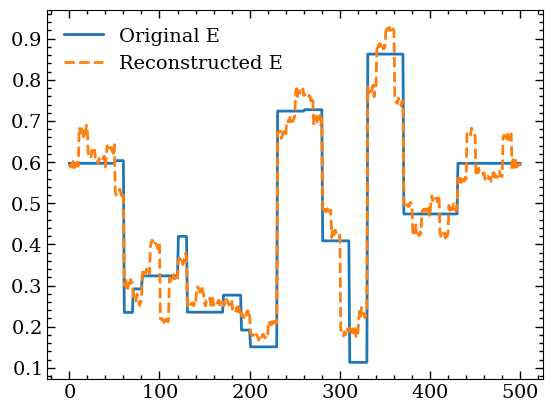

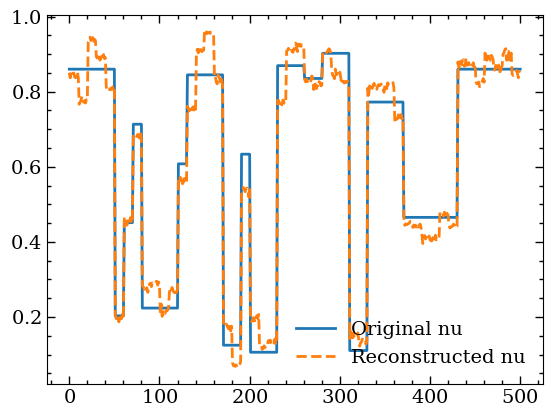

In [24]:
n = 8
E_recon = ae_E(E).detach().numpy()
nu_recon = ae_nu(nu).detach().numpy()
print("E reconstruction error:", loss_function.L2RelativeError(torch.tensor(E_recon).unsqueeze(-1), E.unsqueeze(-1)).item())
print("nu reconstruction error:", loss_function.L2RelativeError(torch.tensor(nu_recon).unsqueeze(-1), nu.unsqueeze(-1)).item())
plt.figure()
plt.plot(E.detach().numpy()[n], label='Original E')
plt.plot(E_recon[n], '--', label='Reconstructed E')
plt.legend()
plt.figure()
plt.plot(nu.detach().numpy()[n], label='Original nu')
plt.plot(nu_recon[n], '--', label='Reconstructed nu')
plt.legend()
plt.show()


In [100]:
energy_input_dim = args.encoder_latent_dim * 2 + 2
energy_hidden_dim = args.hidden_dim
dissipation_input_dim = (1, 1, args.encoder_latent_dim * 2)
dissipation_hidden_dim = args.hidden_dim

vmm = mm.ViscoelasticMaterialModelM(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
).to(device)

vmm.load_state_dict(torch.load(f"material_model_run_{args.run_id}/vmm.pth", weights_only=True, map_location=torch.device('cpu')))

spred, xipred = mm.prediction_step_M(vmm, e, e_dot, E, nu)

In [106]:
xipred.shape

torch.Size([1000, 101, 1])

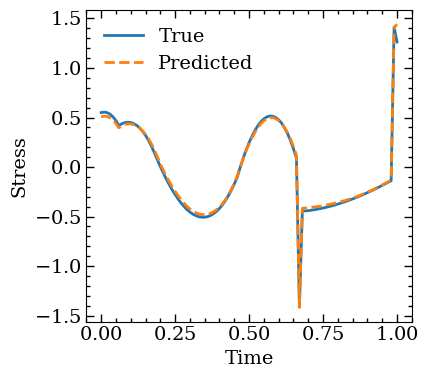

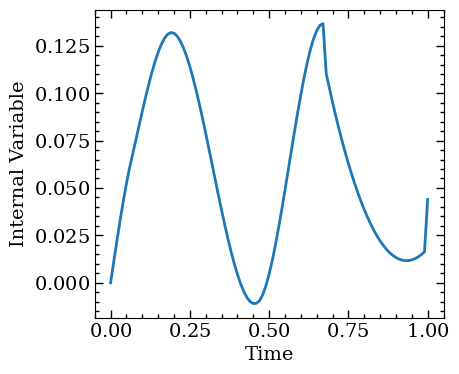

In [109]:
id = 41
time = torch.linspace(0, 1, s.shape[1])
plt.figure(figsize=(4.5,4))
plt.plot(time, s[id, :, 0].cpu().detach().numpy(), label="True")
plt.plot(time, spred[id, :, 0].cpu().detach().numpy(), '--', label="Predicted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Stress")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4.5,4))
plt.plot(time, xipred[id, :, 0].cpu().detach().numpy(), label="True")
plt.xlabel("Time")
plt.ylabel("Internal Variable")
plt.show()


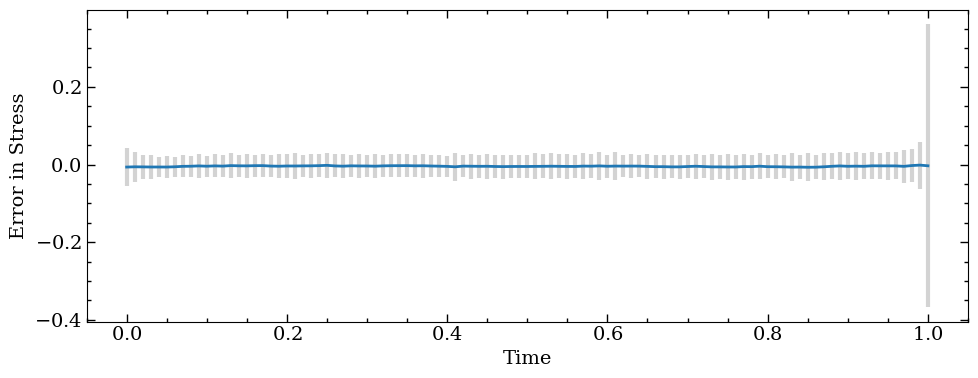

In [116]:
error = s - spred
mean = torch.mean(error, dim=0)
std = torch.std(error, dim=0)
plt.figure(figsize=(10,4))
plt.errorbar(time,
            mean[:, 0].cpu().detach().numpy(),
            yerr=std[:, 0].cpu().detach().numpy(),
            ecolor='lightgray',
            elinewidth=3,
            )
plt.xlabel("Time")
plt.ylabel("Error in Stress")
plt.tight_layout()
plt.show()

## Plot energy and dissipation contours

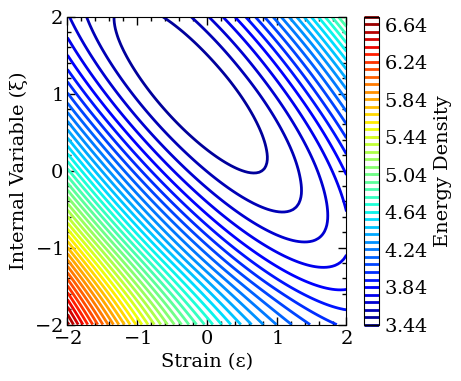

In [92]:
eps = torch.linspace(-2, 2, 100).reshape(-1, 1).to(device)
xi = torch.linspace(-2, 2 , 100).reshape(-1, 1).to(device)
EPS, XI = torch.meshgrid(eps.squeeze(), xi.squeeze(), indexing='ij')
E0 = E[0]
nu0 = nu[0]
inputs = (
        EPS.reshape(-1, 1),
        XI.reshape(-1, 1),
        E0.repeat(EPS.numel(), 1),
        nu0.repeat(EPS.numel(), 1)
        )
Z = vmm.energy_function(*inputs).reshape(EPS.shape).detach().cpu().numpy()

plt.figure(figsize=(4.5,4))
plt.contour(EPS.cpu().numpy(), XI.cpu().numpy(), Z, levels=50, cmap='jet')
plt.colorbar(label='Energy Density')
plt.xlabel('Strain (ε)')
plt.ylabel('Internal Variable (ξ)')
plt.show()

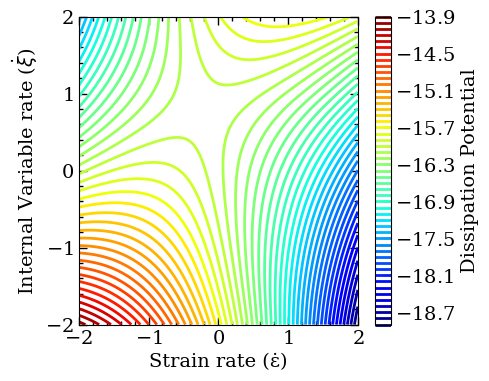

In [93]:
eps_dot = torch.linspace(-2, 2, 100).reshape(-1, 1).to(device)
xi_dot = torch.linspace(-2, 2 , 100).reshape(-1, 1).to(device)
EPS_dot, XI_dot = torch.meshgrid(eps_dot.squeeze(), xi_dot.squeeze(), indexing='ij')
E0 = E[0]
nu0 = nu[0]
inputs = (
        EPS_dot.reshape(-1, 1),
        XI_dot.reshape(-1, 1),
        E0.repeat(EPS.numel(), 1),
        nu0.repeat(EPS.numel(), 1)
        )
Z = vmm.dissipation_potential(*inputs).reshape(EPS_dot.shape).detach().cpu().numpy()

plt.figure(figsize=(4.5,4))
plt.contour(EPS_dot.cpu().numpy(), XI_dot.cpu().numpy(), Z, levels=50, cmap='jet')
plt.colorbar(label='Dissipation Potential')
plt.xlabel('Strain rate (ε̇)')
plt.ylabel(r'Internal Variable rate ($\dot{\xi}$)')
plt.show()

## Dissipation contours for fixed strain rate values

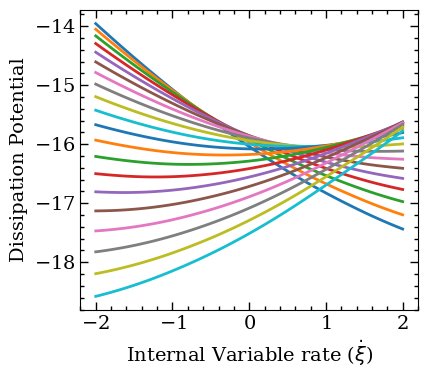

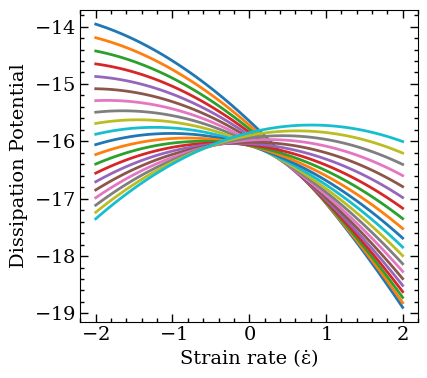

In [94]:
plt.figure(figsize=(4.5,4))
plt.plot(XI_dot[0, :].cpu().detach().numpy(),
        Z.T[:,::5], label='Predicted xi')
plt.xlabel(r'Internal Variable rate ($\dot{\xi}$)')
plt.ylabel('Dissipation Potential')
plt.tight_layout()
plt.show()

plt.figure(figsize=(4.5,4))
plt.plot(EPS[:, 0].cpu().detach().numpy(),
        Z[:,::5], label='Predicted xi')
plt.xlabel('Strain rate (ε̇)')
plt.ylabel('Dissipation Potential')
plt.tight_layout()
plt.show()